In [6]:
import numpy as np
rnd = np.random
rnd.seed(0)

In [7]:
n = 4
Q = 500
N = [i for i in range(1, n+1)]
V = [0] + N
q = {i: rnd.randint(1, 10) for i in N}

In [8]:
#input
loc_y= np.array([11.026829830511458, 11.000032289646322, 11.009194665389133, 10.89167346812154, 11.026996214865315])
loc_x= np.array([76.93035690329974, 76.95381913315647, 76.95947192353994, 76.99085176956464, 76.94524171004645])

(76.92733215998649, 76.99387651287789, 10.884907330784351, 11.033762352202505)

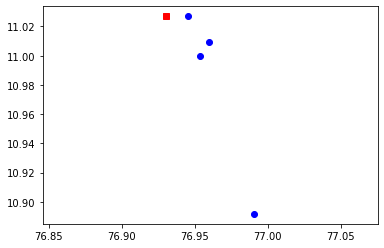

In [9]:
import matplotlib.pyplot as plt
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

In [12]:
from docplex.mp.model import Model
mdl = Model('CVRP')

In [13]:
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i, j in A}

In [14]:
x = mdl.binary_var_dict(A, name='x')
u = mdl.continuous_var_dict(N, ub=Q, name='u')

In [15]:
mdl.minimize(mdl.sum(c[i, j]*x[i, j] for i, j in A))
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i]+q[j] == u[j]) for i, j in A if i != 0 and j != 0)
mdl.add_constraints(u[i] >= q[i] for i in N)
mdl.parameters.timelimit = 15
solution = mdl.solve(log_output=True)

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               15
Found incumbent of value 0.465239 after 0.00 sec. (0.00 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 4 rows and 0 columns.
MIP Presolve modified 6 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 14 rows, 30 columns, and 50 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 12 indicators.
Presolve time = 0.02 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 14 rows, 30 columns, and 50 nonzeros.
Reduced MIP has 20 binaries, 0 generals, 0 SOSs, and 12 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Clique table members: 14.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution t

In [16]:
print(solution)

solution for: CVRP
objective: 0.309444
x_0_1=1
x_1_3=1
x_2_4=1
x_3_2=1
x_4_0=1
u_1=6.000
u_2=11.000
u_3=10.000
u_4=15.000



In [78]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]

(76.92733215998649, 76.99387651287789, 10.884907330784351, 11.033762352202505)

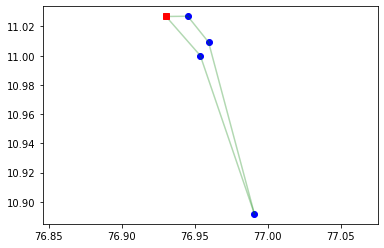

In [43]:
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
for i, j in active_arcs:
    plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c='g', alpha=0.3)
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

In [39]:
#plot the solution in a map using folium
import folium
from folium import plugins

# create map

m = folium.Map(location=[loc_y.mean(), loc_x.mean()], zoom_start=10)

# add home 
folium.Marker([loc_y[0], loc_x[0]], popup='Home', icon=folium.Icon(color='red', icon='home')).add_to(m)
# add markers
for i in N:
        folium.Marker([loc_y[i], loc_x[i]], popup=(loc_y[i], loc_x[i])).add_to(m)

# add lines
for i, j in active_arcs:

    folium.PolyLine(locations=[[loc_y[i], loc_x[i]], [loc_y[j], loc_x[j]]], color='red', weight=2.5, opacity=1).add_to(m)

# display map
m


In [86]:
print(active_arcs)
sorted_coords = [active_arcs[0]]

while len(sorted_coords)!=len(active_arcs):
    for i in active_arcs:
        if i in sorted_coords:
            continue
        last = len(sorted_coords)-1
        print(sorted_coords)
        if sorted_coords[last][1] == i[0]:
            sorted_coords.append(i)
print(sorted_coords)



[(0, 1), (1, 3), (2, 4), (3, 2), (4, 0)]
[(0, 1)]
[(0, 1), (1, 3)]
[(0, 1), (1, 3)]
[(0, 1), (1, 3), (3, 2)]
[(0, 1), (1, 3), (3, 2)]
[(0, 1), (1, 3), (3, 2), (2, 4)]
[(0, 1), (1, 3), (3, 2), (2, 4), (4, 0)]


In [88]:
stops_arranged = ""
for i, j in sorted_coords:
    stops_arranged+=loc_y[i].astype(str)+","+loc_x[i].astype(str)+"|"
    print(stops_arranged)

11.026829830511458,76.93035690329974|
11.026829830511458,76.93035690329974|11.000032289646322,76.95381913315647|
11.026829830511458,76.93035690329974|11.000032289646322,76.95381913315647|10.89167346812154,76.99085176956464|
11.026829830511458,76.93035690329974|11.000032289646322,76.95381913315647|10.89167346812154,76.99085176956464|11.009194665389133,76.95947192353994|
11.026829830511458,76.93035690329974|11.000032289646322,76.95381913315647|10.89167346812154,76.99085176956464|11.009194665389133,76.95947192353994|11.026996214865315,76.94524171004645|


In [89]:
import requests

url = "https://trueway-directions2.p.rapidapi.com/FindDrivingRoute"

querystring = {"stops":stops_arranged}

headers = {
    "X-RapidAPI-Key": "954bd9e800mshf505c10f126c98dp193b7cjsnf78c048d56c5",
    "X-RapidAPI-Host": "trueway-directions2.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{
  "route": {
    "distance": 41787,
    "duration": 6270,
    "bounds": {
      "south": 10.886237,
      "west": 76.930427,
      "north": 11.027037,
      "east": 77.000937
    },
    "geometry": {
      "coordinates": [
        [
          11.026675,
          76.930427
        ],
        [
          11.026675,
          76.930437
        ],
        [
          11.026695,
          76.930548
        ],
        [
          11.026725,
          76.930801
        ],
        [
          11.026725,
          76.930821
        ],
        [
          11.026735,
          76.930993
        ],
        [
          11.026725,
          76.931155
        ],
        [
          11.026705,
          76.931267
        ],
        [
          11.026705,
          76.931328
        ],
        [
          11.026675,
          76.931694
        ],
        [
          11.026655,
          76.931939
        ],
        [
          11.026644,
          76.932194
        ],
        [
          11.026624,


In [90]:
import json
data = json.loads(response.text)
coords=(data['route']['geometry']['coordinates'])

for j,k in coords:
    print(j,k)


11.026675 76.930427
11.026675 76.930437
11.026695 76.930548
11.026725 76.930801
11.026725 76.930821
11.026735 76.930993
11.026725 76.931155
11.026705 76.931267
11.026705 76.931328
11.026675 76.931694
11.026655 76.931939
11.026644 76.932194
11.026624 76.932255
11.026614 76.932417
11.026614 76.932509
11.026675 76.93323
11.026685 76.933382
11.026715 76.933684
11.026755 76.933805
11.026604 76.933916
11.02622 76.934156
11.025763 76.934466
11.02553 76.934616
11.025479 76.934666
11.025377 76.934725
11.025224 76.934825
11.025132 76.934894
11.02501 76.935003
11.024694 76.935221
11.024582 76.93528
11.024287 76.935468
11.023902 76.935685
11.023507 76.93594
11.023335 76.936058
11.022803 76.936412
11.022773 76.936431
11.022663 76.936529
11.022145 76.936893
11.021818 76.937158
11.021739 76.937227
11.021414 76.937404
11.021237 76.937552
11.02101 76.93767
11.020863 76.937749
11.020588 76.937908
11.020412 76.938037
11.019803 76.938404
11.019567 76.938554
11.019488 76.938594
11.019438 76.938674
11.01932

In [91]:
import folium
import pandas as pd


def create_map(response):
   # use the response
   mls = response
   points = [(i,k) for i,k in mls]
   m = folium.Map(location=[loc_y.mean(), loc_x.mean()], zoom_start=10)
   # add marker
   folium.Marker([loc_y[0], loc_x[0]], popup='Home', icon=folium.Icon(color='red', icon='home')).add_to(m)
   for i in N:
        folium.Marker([loc_y[i], loc_x[i]], popup='q_%d=%d' % (i, q[i])).add_to(m)
   folium.PolyLine(points, weight=5, opacity=1).add_to(m)
   return m
m = create_map(coords)
m